In [1]:
#installing the necessary package 
! pip install -q 'gwosc==0.5.4' 
#checking which version was installed
import gwosc
print(gwosc.__version__) 
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
! pip install matplotlib==3.1.3
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'

#packages:
import numpy
import pylab
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.filter import resample_to_delta_t, highpass
from pycbc import frame
from pycbc.psd import interpolate, inverse_spectrum_truncation


# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')
print(gwpy_strain)

Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  26.2MB/s    in 55s     

2022-02-14 22:54:08 (4.42 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]

TimeSeries([-3.04517369e-19, -3.35465069e-19, -3.35210566e-19,
            ...,  4.46471052e-19,  5.07624678e-19,
             4.98623016e-19]
           unit: ct,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE3,
           channel: H1:CHALLENGE3)


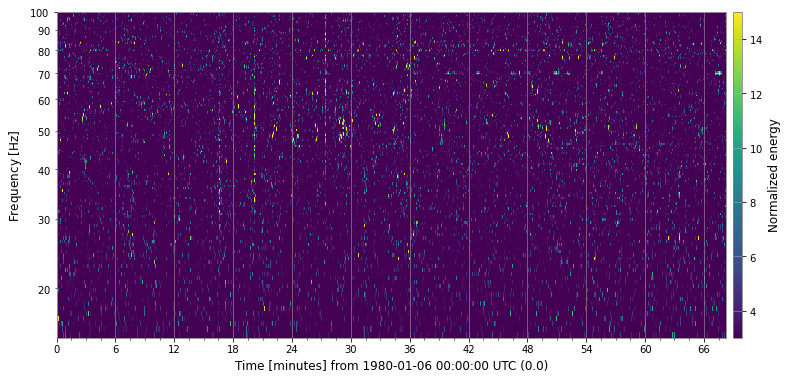

In [2]:
#Exercise 1
#Creating a Q transform to find the time of the merger
hq = gwpy_strain.q_transform(frange=(15, 100), qrange=(100, 300))
plot = hq.plot() #plotting the q-transform 
ax = plot.gca() #defining the axis
ax.set_yscale('log')  #scaling the y axis as a logarithmic 
plot.add_colorbar(cmap='viridis', label='Normalized energy') #adding a colorbar with the label 
plot.colorbars[0].mappable.set_clim(3, 15)

This Q transform is normally helpful to find the time of the merger. As I was not able to find a clear signal here, I hope that the SNR helps in figuring out the time of the merger.

EXERCISE 2:
FINDING THE SNR
MATCHED FILTERING: Matched filtering is a process in which a template is compared to a signal and the signal to noise ratio (SNR) is calculated for every time step. This means every part of th e template gets moved over every part of the signal. If there is a SNR over 8, a signal is found.

In [3]:
#Necessary variables
sample_rate = 1024 # samples per second
#this is the variable for the approximant, which is a paramterized wavefrom family
apx = 'SEOBNRv4_opt'
#variable for the masses
m = 10 #solar masses

In [5]:
#Preconditioning the data
# Remove the low frequency content and downsample the data to 2048Hz
pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)
#removing 2 sec from beginning and end
condition = pycbc_strain.crop(2, 2)

In [7]:
# Estimating the power spectral density again, this time with the preconditioned data to make the SNR calculation easier

# We use 4 second samples of our time series in Welch method, whicha s mentioned erlaier takes pieces of data and combines then
psd = condition.psd(4)
#After having created our new psd, it is necessary to interpolate it so it properly matches our data and to limit the filter length of 1/PSD
 
psd = interpolate(psd, condition.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
#As we have have highpassed our frequency with 15 and thus excluded frequencies below that, our low frequency cut off is at 15 Hz.
psd = inverse_spectrum_truncation(psd, int(4 * condition.sample_rate),
                                  low_frequency_cutoff=15)


In [13]:
#now we need to also redo the creation of the template, as we need to have the delta t match our new, preconditioned data, described by the variable condition

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=condition.delta_t,
                    f_lower=25)



# Now we have to resize the vector to match our data
hp.resize(len(condition))

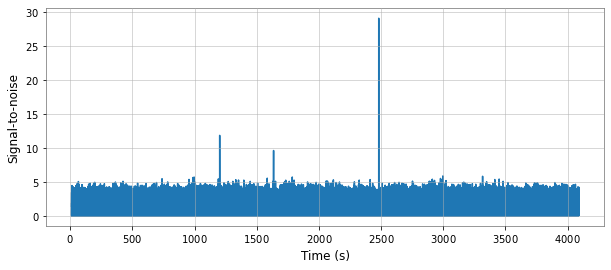

We found a signal at 2480.7119140625s with SNR 29.049338889878054


In [14]:
#this is the final step: calculating the SNR
# To do this, the template (hp) will be cross correlated with the data (condition). The psd is the psd and the low frequency cut off is 20.
snr = matched_filter(hp, condition, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4]) #defining the sizes of the plot
pylab.plot(snr.sample_times, abs(snr)) #plotting the snar value against the time
pylab.ylabel('Signal-to-noise') #naming the y axis
pylab.xlabel('Time (s)') #naming the x axis
pylab.show() #printing the plot

peak = abs(snr).numpy().argmax() # defining the paek as the maximal snr value in this data 
snrp = snr[peak] #the value for the snr at the peak 
time = snr.sample_times[peak] #time at which the peak is found

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

It appears that there is a very high SNR value at 2480 s with an SNR of 29. This also answers the first question: the merger was at 2480 seconds.